# Sports Networks: Limits of PageRank-based ranking methods in sports data
Click on `Run/Run All Cells` before starting (ensure that the collapsed cells are executed). 

In [1]:
import math, random, itertools

import pandas as pd
import numpy as np
from copy import deepcopy
import networkx as nx

from scipy.stats import rankdata
from scipy.stats.mstats import kendalltau
    
from random import choices

from tqdm.notebook import trange, tqdm

In [2]:
#############################################################################################
# configuration expansion

def expand_configuration(config):
    experiments = []

    for n_teams in config["n_teams"]:

        for fitness_d in _expand_fitness(n_teams, config["fitness"]):

            for model_d in _expand_model(config["model"]):

                for fraction_games_per_season in config["fraction_games_per_season"]: 

                    for season in range(config["n_seasons"]): # repetition
                        d = {
                            "n_teams": n_teams,
                            **fitness_d,
                            **model_d,
                            "fraction_games_per_season": fraction_games_per_season,
                            "season": season
                        }
                        experiments.append(d)
    
    return experiments



def _expand_fitness(n_teams, fitness_config):
    
    fitness_exp = []
    
    for fitness in fitness_config:
        if fitness["type"] == "linear":
            d = {
                "fitness_type": "linear",
                "fitness_values": linear_fitness(N=n_teams) 
            }
            fitness_exp.append(d)
        elif fitness["type"] == "nonlinear":
            fitness_values = []
            for alpha, beta, gamma in itertools.product(fitness["alpha"], fitness["beta"], fitness["gamma"]):
                fitness_values += []
                
                d = {
                    "fitness_type": "nonlinear",
                    "fitness_nonlinear_alpha": alpha,
                    "fitness_nonlinear_beta": beta,
                    "fitness_nonlinear_gamma": gamma,                    
                    "fitness_values": nonlinear_fitness(N=n_teams, alpha=alpha, beta=beta, gamma=gamma)
                }
                fitness_exp.append(d)

        else:
            raise ValueError(f"unknown fitness: {fitness}")
    
    return fitness_exp


def _expand_model(model_config):
    
    model_exp = []
    
    for model in model_config:
        if model["type"] == "logistic":
            for H, delta in itertools.product(model["H"], model["delta"]):
                d = {
                    "model": "logistic",
                    "model_logistic_H": H,
                    "model_logistic_delta": delta
                }
                model_exp.append(d)
        else:
            raise ValueError(f"unknown model: {model}")
        
    return model_exp



#############################################################################################
# fitness levels

def linear_fitness(N):
    return [(i-0.5)/N  for i in range(1, N+1)]

def nonlinear_fitness(N, alpha, beta, gamma):
    
    gamma0 = 0 if gamma == "fix" else gamma 
    
    fitness_values = [beta * (((i-0.5)/N) ** alpha) + gamma0  for i in range(1, N+1)]
    
    if gamma == "fix": # choose gamma such that avg fitness level == 0.5
        gamma0 = 0.5 - sum(fitness_values) / N
        fitness_values = [x + gamma0 for x in fitness_values]
        
    return fitness_values

#############################################################################################
# models

def logistic_model(f_i, f_j, H, delta):
    # f_i fitness value of team i (home team)
    # f_j fitness value of team j (away team)
    # H: home advantage
    # delta: randomness factor
    return sigmoid((f_i - f_j + H)/delta)

# TODO: in the paper math formula, I think they have an additional ^-1 which is wrong
def sigmoid(x):
    return 1 / (1 + math.exp(-x))

#############################################################################################
# simulate games

def generate_synthetic_sports_results(exp):
    # fraction of games can also be > 1 (league where teams play more than once against each other)
    
    assert(len(exp["fitness_values"])==exp["n_teams"])
    
    n_games = exp["fraction_games_per_season"] * (exp["n_teams"] - 1)
    
    # TODO: implement as described in paper (ceil(n_games) or floor(n_games) such that total number of games is N/2 * n_games)
    n_games = int(n_games)
    
    sequence = [n_games] * exp["n_teams"]
    
    # TODO with this approach you can only create a graph with fraction_of_games<=1
    G = nx.random_degree_sequence_graph(sequence, seed=42)
    
    #nx.draw(G)
    
    games = []
    for edge in G.edges():
        # home team is chosen at random for each game
        home_team_idx = random.randint(0, 1)
        away_team_idx = (home_team_idx + 1) % 2 
        
        home_team = edge[home_team_idx]
        away_team = edge[away_team_idx]
        
        if exp["model"] == "logistic": 
            prob_home_team_win = logistic_model(f_i=exp["fitness_values"][home_team], f_j=exp["fitness_values"][away_team], H=exp["model_logistic_H"], delta=exp["model_logistic_delta"])
            home_team_win = bool(np.random.binomial(n=1, p=prob_home_team_win))
            
            result = "home" if home_team_win else "away"
        else:
            raise ValueError(f"Not Implemented Yet: model={model}")
        
        game = {
            "home": home_team,
            "away": away_team,
            "result": result
        }
        
        #print(f"edge={edge} game={game}")
        
        games.append(game)
        
    return games

#############################################################################################
# game results to graph

def games_to_graph(n_teams, games, graph="winner"):
    
    G = nx.DiGraph(directed=True)
    G.add_nodes_from(range(0, n_teams))
    
    edges = []
    for game in games:
           
        if game["result"] == "home":
            winner = game["home"]
            loser = game["away"]
        elif game["result"] == "away":
            winner = game["away"]
            loser = game["home"]
        else:
            raise ValueError("Not Implemented Yet")
        
        if graph == "winner":
            # when team i wins against team j => a directed link from j to i "along which sports prestige flows"
            e = (loser, winner, 1)
        elif graph == "loser":
             # when team i wins against team j => a directed link from i to j
            e = (winner, loser, 1)
        else:
            raise ValueError(f"unknown graph type: {graph}")
        edges.append(e)
    
    # TODO at the moment each team can only against each other team once => don't need to combine edge weights
    
    G.add_weighted_edges_from(edges) # (start node, dest node, weight)
    
    return G

#############################################################################################
# ranking algos

def winratio(winner_graph):
    scores = {}
            
    for team in winner_graph.nodes():
        n_wins = winner_graph.in_degree(team)
        n_losses = winner_graph.out_degree(team)
        win_ratio = n_wins / (n_wins + n_losses)
        scores[team] =  win_ratio
    return scores
    

def bipagerank(winner_graph, loser_graph):
    scores_P = nx.pagerank(winner_graph)
    scores_Q = nx.pagerank(loser_graph)
            
    scores = {}
    for team, score_P in scores_P.items():
        score_Q = scores_Q[team]
        scores[team] = score_P - score_Q
    
    return scores


def scores_to_ranking(scores):
    
    # sort team by team index
    team_scores = [score for team, score in sorted(scores.items(), key=lambda item: item[0])]
    
    # apply the ranking
    ranking = rankdata(team_scores, method='min')
    
    # convert ranking to dictionary (same form as scores)
    ranking_d = {team: rank for team, rank in enumerate(ranking)}
    
    return ranking, ranking_d 
    

#############################################################################################

# metrics
def topk_avg_rank(ranking_d, ranking_gt, k=5):
    
    rank_sum = 0
    for team in ranking_gt[:k]:
        rank_sum += ranking_d[team]
                
    return rank_sum / k

def kendall(ranking, ranking_gt):
    tau_a, _ = kendalltau(ranking, ranking_gt, use_ties=False, use_missing=False, method='auto')
    return tau_a

print("Kendall Score Test: ")

ranking = [1, 1, 1, 1, 1]
ranking_gt = [1, 2, 3, 4, 5]
score = kendall(ranking, ranking_gt)
print(f"- degenerate ranking: {score}")

ranking_gt = [1, 2, 3, 4, 5]
ranking = ranking_gt
score = kendall(ranking, ranking_gt)
print(f"- same ranking: {score}")

ranking_gt = [1, 2, 3, 4, 5]
ranking = [5, 4, 3, 2, 1]
score = kendall(ranking, ranking_gt)
print(f"- reverse ranking: {score}")

def auc(ranking_d, ranking_gt, n, topk=5):
    
    goal_top_set = ranking_gt[:topk]
    ordinary_set = ranking_gt[topk:]

    # sample with replacement
    goal_top_set_samples = choices(goal_top_set,k=n)
    ordinary_set_samples = choices(ordinary_set,k=n)
    
    goal_higher_count = 0
    tied_count = 0
    for goal_team, ordinary_team in zip(goal_top_set_samples, ordinary_set_samples):
        goal_team_rank = ranking_d[goal_team]
        ordinary_team_rank = ranking_d[ordinary_team]
        if goal_team_rank > ordinary_team_rank:
            goal_higher_count+= 1
        elif goal_team_rank == ordinary_team_rank:
            tied_count += 1
    
    auc = (goal_higher_count + tied_count/2) / n
    
    return auc
        

#############################################################################################


Kendall Score Test: 
- degenerate ranking: 0.0
- same ranking: 1.0
- reverse ranking: -1.0


In [3]:
def build_df(config):   
    experiments = expand_configuration(config)
    
    print(f"Config results in {len(experiments)} experiments")

    # simulate seasons
    for exp in tqdm(experiments):

        exp["results"] = generate_synthetic_sports_results(exp)

        winner_graph = games_to_graph(n_teams=exp["n_teams"], games=exp["results"], graph="winner")


        exp["gt_ranking"] = sorted(range(len(exp["fitness_values"])), key=lambda i: exp["fitness_values"][i], reverse=True)

        # apply the ranking algorithms to the simulated seasons
        for ranking_algo in config["ranking_algos"]:
            if ranking_algo == "pagerank":
                scores = nx.pagerank(winner_graph)
            elif ranking_algo == "bipagerank":
                loser_graph = games_to_graph(n_teams=exp["n_teams"], games=exp["results"], graph="loser")
                scores = bipagerank(winner_graph, loser_graph)

            elif ranking_algo == "winratio":
                scores = winratio(winner_graph)

            else:
                raise ValueError(f"unknown ranking algo: {ranking_algo}")            
            
            ranking, ranking_d = scores_to_ranking(scores)

            exp[f"{ranking_algo}_scores"] = scores
            exp[f"{ranking_algo}_ranking"] = ranking_d
            
            # evaluate each ranking with the defined metrics
            for metric in config["metrics"]:
                if metric == "top5_avg_rank":
                    metric_score = topk_avg_rank(ranking_d, ranking_gt=exp["gt_ranking"], k=5)

                elif metric == "kendall":
                    metric_score = kendall(ranking, ranking_gt=exp["gt_ranking"])

                elif metric == "auc":
                    metric_score = auc(ranking_d, ranking_gt=exp["gt_ranking"], n=100 , topk=5) # n is the number of sampled pairs

                else:
                    raise ValueError(f"unknown metric: {metric}")

                exp[f"{ranking_algo}_{metric}"] = metric_score
   
    df = pd.DataFrame(experiments)
    
    # only keep the important columns 
    return df

def drop_additional_cols(df1):
    df1 = df1[df1.columns.drop(list(df.filter(regex='_ranking')))]
    df1 = df1[df1.columns.drop(list(df.filter(regex='_scores')))]
    df1 = df1.drop(columns=["fitness_values", "results"])
    return df1

## Example for Pipeline Config

In [4]:
# configure here the experiments (the pipeline will create a cross product for every element in a list)
config = {
    "n_teams": [20],
    "fitness": [{"type": "linear"}, 
                {"type": "nonlinear", "alpha": [1], "beta":[0.4], "gamma": ["fix"] }],
    "model": [{"type": "logistic", "H": [0.1875], "delta": [0.25] }],
    "fraction_games_per_season":  [0.5, 1], # P in paper (can only be between [0,1])
    "n_seasons": 3, # number of repetitions
    "ranking_algos": ["pagerank", "bipagerank", "winratio"],
    "metrics": ["top5_avg_rank", "kendall", "auc"]
}

df = build_df(config)

display(drop_additional_cols(df))

Config results in 12 experiments


  0%|          | 0/12 [00:00<?, ?it/s]

,n_teams,fitness_type,model,model_logistic_H,model_logistic_delta,fraction_games_per_season,season,pagerank_top5_avg_rank,pagerank_kendall,pagerank_auc,bipagerank_top5_avg_rank,bipagerank_kendall,bipagerank_auc,winratio_top5_avg_rank,winratio_kendall,winratio_auc,fitness_nonlinear_alpha,fitness_nonlinear_beta,fitness_nonlinear_gamma
0,20,linear,logistic,0.1875,0.25,0.5,0,16.0,-0.626316,0.83,16.4,-0.631579,0.86,16.0,-0.673684,0.935,NaN,NaN,NaN
1,20,linear,logistic,0.1875,0.25,0.5,1,15.4,-0.505263,0.87,16.0,-0.431579,0.87,14.6,-0.547368,0.850,NaN,NaN,NaN
2,20,linear,logistic,0.1875,0.25,0.5,2,15.0,-0.315789,0.82,15.2,-0.515789,0.85,16.2,-0.652632,0.950,NaN,NaN,NaN
3,20,linear,logistic,0.1875,0.25,1.0,0,16.4,-0.578947,0.94,17.6,-0.778947,0.98,17.4,-0.836842,0.975,NaN,NaN,NaN
4,20,linear,logistic,0.1875,0.25,1.0,1,18.0,-0.673684,1.00,17.2,-0.621053,0.94,16.4,-0.721053,0.990,NaN,NaN,NaN
5,20,linear,logistic,0.1875,0.25,1.0,2,16.2,-0.600000,0.93,17.0,-0.663158,0.88,17.2,-0.642105,0.945,NaN,NaN,NaN
6,20,nonlinear,logistic,0.1875,0.25,0.5,0,15.4,-0.336842,0.78,16.0,-0.452632,0.86,14.4,-0.489474,0.845,1.0,0.4,fix
7,20,nonlinear,logistic,0.1875,0.25,0.5,1,15.0,-0.421053,0.84,14.8,-0.294737,0.78,15.2,-0.505263,0.880,1.0,0.4,fix
8,20,nonlinear,logistic,0.1875,0.25,0.5,2,12.2,-0.294737,0.64,11.0,-0.189474,0.51,14.0,-0.526316,0.760,1.0,0.4,fix
9,20,nonlinear,logistic,0.1875,0.25,1.0,0,14.4,-0.400000,0.79,14.2,-0.368421,0.78,13.2,-0.357895,0.785,1.0,0.4,fix


## Figure 3

In [50]:
%time
# (~ 9 min) 

# configure here the experiments (the pipeline will create a cross product for every element in a list)
config = { 
    "n_teams": [30],
    "fitness": [{"type": "linear"}],
    "model": [{"type": "logistic", "H": [0], "delta": np.linspace(0.01,0.35, 10) }],
    "fraction_games_per_season":  [0.1, 0.3, 0.8], # P in paper (can only be between [0,1])
    "n_seasons": 100, # number of repetitions
    "ranking_algos": ["pagerank", "bipagerank", "winratio"],
    "metrics": ["kendall", "auc", "top5_avg_rank"]
}

df = build_df(config)

display(drop_additional_cols(df))

CPU times: user 1e+03 ns, sys: 1 µs, total: 2 µs
Wall time: 4.77 µs
Config results in 3000 experiments


  0%|          | 0/3000 [00:00<?, ?it/s]

TypeError: 'Series' object is not callable

In [6]:
display(df)

,n_teams,fitness_type,fitness_values,model,model_logistic_H,model_logistic_delta,fraction_games_per_season,season,results,gt_ranking,...,bipagerank_scores,bipagerank_ranking,bipagerank_top5_avg_rank,bipagerank_kendall,bipagerank_auc,winratio_scores,winratio_ranking,winratio_top5_avg_rank,winratio_kendall,winratio_auc
0,30,linear,"[0.016666666666666666, 0.05, 0.083333333333333...",logistic,0,0.01,0.1,0,"[{'home': 0, 'away': 19, 'result': 'away'}, {'...","[29, 28, 27, 26, 25, 24, 23, 22, 21, 20, 19, 1...",...,"{0: -0.017216553351781273, 1: -0.0172165533517...","{0: 6, 1: 6, 2: 6, 3: 6, 4: 2, 5: 1, 6: 6, 7: ...",20.0,-0.455172,0.800,"{0: 0.0, 1: 0.0, 2: 0.0, 3: 0.0, 4: 0.0, 5: 0....","{0: 1, 1: 1, 2: 1, 3: 1, 4: 1, 5: 1, 6: 1, 7: ...",19.0,-0.464368,0.820
1,30,linear,"[0.016666666666666666, 0.05, 0.083333333333333...",logistic,0,0.01,0.1,1,"[{'home': 19, 'away': 0, 'result': 'home'}, {'...","[29, 28, 27, 26, 25, 24, 23, 22, 21, 20, 19, 1...",...,"{0: -0.017216553351781273, 1: -0.0172165533517...","{0: 6, 1: 6, 2: 6, 3: 6, 4: 2, 5: 1, 6: 6, 7: ...",20.0,-0.455172,0.815,"{0: 0.0, 1: 0.0, 2: 0.0, 3: 0.0, 4: 0.0, 5: 0....","{0: 1, 1: 1, 2: 1, 3: 1, 4: 1, 5: 1, 6: 1, 7: ...",19.0,-0.464368,0.895
2,30,linear,"[0.016666666666666666, 0.05, 0.083333333333333...",logistic,0,0.01,0.1,2,"[{'home': 19, 'away': 0, 'result': 'home'}, {'...","[29, 28, 27, 26, 25, 24, 23, 22, 21, 20, 19, 1...",...,"{0: -0.017216553351781273, 1: -0.0172165533517...","{0: 6, 1: 6, 2: 6, 3: 6, 4: 2, 5: 1, 6: 6, 7: ...",20.0,-0.455172,0.850,"{0: 0.0, 1: 0.0, 2: 0.0, 3: 0.0, 4: 0.0, 5: 0....","{0: 1, 1: 1, 2: 1, 3: 1, 4: 1, 5: 1, 6: 1, 7: ...",19.0,-0.464368,0.825
3,30,linear,"[0.016666666666666666, 0.05, 0.083333333333333...",logistic,0,0.01,0.1,3,"[{'home': 19, 'away': 0, 'result': 'home'}, {'...","[29, 28, 27, 26, 25, 24, 23, 22, 21, 20, 19, 1...",...,"{0: -0.017216553351781273, 1: -0.0172165533517...","{0: 6, 1: 6, 2: 6, 3: 6, 4: 2, 5: 1, 6: 6, 7: ...",20.0,-0.455172,0.830,"{0: 0.0, 1: 0.0, 2: 0.0, 3: 0.0, 4: 0.0, 5: 0....","{0: 1, 1: 1, 2: 1, 3: 1, 4: 1, 5: 1, 6: 1, 7: ...",19.0,-0.464368,0.855
4,30,linear,"[0.016666666666666666, 0.05, 0.083333333333333...",logistic,0,0.01,0.1,4,"[{'home': 0, 'away': 19, 'result': 'away'}, {'...","[29, 28, 27, 26, 25, 24, 23, 22, 21, 20, 19, 1...",...,"{0: -0.017216553351781273, 1: -0.0172165533517...","{0: 6, 1: 6, 2: 6, 3: 6, 4: 2, 5: 1, 6: 6, 7: ...",20.0,-0.455172,0.840,"{0: 0.0, 1: 0.0, 2: 0.0, 3: 0.0, 4: 0.0, 5: 0....","{0: 1, 1: 1, 2: 1, 3: 1, 4: 1, 5: 1, 6: 1, 7: ...",19.0,-0.464368,0.830
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2995,30,linear,"[0.016666666666666666, 0.05, 0.083333333333333...",logistic,0,0.35,0.8,95,"[{'home': 0, 'away': 28, 'result': 'away'}, {'...","[29, 28, 27, 26, 25, 24, 23, 22, 21, 20, 19, 1...",...,"{0: -0.05510260735614243, 1: -0.06487445935219...","{0: 3, 1: 1, 2: 2, 3: 4, 4: 5, 5: 15, 6: 7, 7:...",26.8,-0.733333,0.930,"{0: 0.08695652173913043, 1: 0.1739130434782608...","{0: 1, 1: 3, 2: 2, 3: 3, 4: 6, 5: 10, 6: 7, 7:...",26.2,-0.800000,0.945
2996,30,linear,"[0.016666666666666666, 0.05, 0.083333333333333...",logistic,0,0.35,0.8,96,"[{'home': 28, 'away': 0, 'result': 'home'}, {'...","[29, 28, 27, 26, 25, 24, 23, 22, 21, 20, 19, 1...",...,"{0: -0.0460781548008254, 1: -0.037376243946596...","{0: 1, 1: 3, 2: 8, 3: 5, 4: 10, 5: 4, 6: 9, 7:...",24.4,-0.719540,0.880,"{0: 0.13043478260869565, 1: 0.3043478260869565...","{0: 1, 1: 4, 2: 4, 3: 3, 4: 10, 5: 2, 6: 9, 7:...",22.8,-0.705747,0.795
2997,30,linear,"[0.016666666666666666, 0.05, 0.083333333333333...",logistic,0,0.35,0.8,97,"[{'home': 0, 'away': 28, 'result': 'away'}, {'...","[29, 28, 27, 26, 25, 24, 23, 22, 21, 20, 19, 1...",...,"{0: -0.04619957661074023, 1: -0.02892379726888...","{0: 1, 1: 5, 2: 9, 3: 3, 4: 10, 5: 8, 6: 15, 7...",26.4,-0.710345,0.910,"{0: 0.13043478260869565, 1: 0.3043478260869565...","{0: 1, 1: 4, 2: 10, 3: 3, 4: 7, 5: 4, 6: 14, 7...",26.2,-0.696552,0.945
2998,30,linear,"[0.0166666666

# Plotting

In [53]:
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D


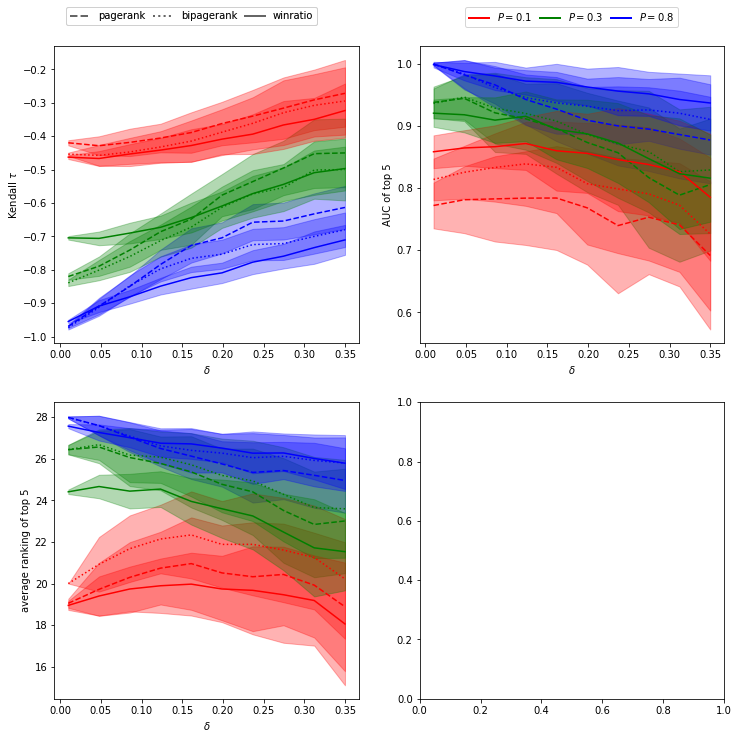

[[<AxesSubplot:xlabel='$\\delta$', ylabel='Kendall $\\tau$'>
  <AxesSubplot:xlabel='$\\delta$', ylabel='AUC of top 5'>]
 [<AxesSubplot:xlabel='$\\delta$', ylabel='average ranking of top 5'>
  <AxesSubplot:>]]


In [68]:
COLOR_GRAY = '#666666'

plot_config = {
    'colors': {
        0.1: 'red',
        0.3: 'green',
        0.8: 'blue'
    },
    'linestyles': {
        "pagerank": "dashed",
        "bipagerank": "dotted",
        "winratio": "solid"
    },
    'ylabels': {
        "top5_avg_rank": "average ranking of top 5",
        "kendall": "Kendall $\\tau$",
        "auc": "AUC of top 5"
    }
}
# figure 3
fig, axes = plt.subplots(2, 2, figsize=[12, 12])
fig.subplots_adjust(wspace=0.2, hspace=0.2)

for index, metric in enumerate(config['metrics']):
    for algo in config['ranking_algos']:
        for fraction in config['fraction_games_per_season']:
            rows = df[df[f"fraction_games_per_season"] == fraction]
            groups = rows.groupby("model_logistic_delta")
            labels = groups.groups.keys()
            
            suffix = f"{algo}_{metric}"
            values = groups.mean()[suffix]
            stderr = groups.std()[suffix]
            axes[int(index / 2), index % 2].plot(labels, values,
                            color=plot_config['colors'][fraction],
                            linestyle=plot_config['linestyles'][algo]
                            )
            axes[int(index / 2), index % 2].fill_between(labels, values - stderr, values + stderr,
                                    color=plot_config['colors'][fraction],
                                    alpha=0.3)

            axes[int(index / 2), index % 2].set_ylabel(plot_config['ylabels'][metric])
            axes[int(index / 2), index % 2].set_xlabel("$\delta$")

legend_algo = [Line2D([0], [0], linestyle=style, lw=2, color=COLOR_GRAY) for style in plot_config['linestyles'].values()]
legend_fraction = [Line2D([0], [0], linestyle='solid', lw=2, color=color) for color in plot_config['colors'].values()]

leg1 = plt.legend(legend_fraction, [f"$P = {fraction}$" for fraction in plot_config['colors'].keys()],
                  bbox_to_anchor=(0.5, 2.35), loc='upper center',
                  ncol=len(plot_config['colors'].keys()), columnspacing=0.75)
leg2 = plt.legend(legend_algo, plot_config['linestyles'].keys(),
                  bbox_to_anchor=(-0.75, 2.35), loc='upper center',
                  ncol=len(plot_config['linestyles'].keys()), columnspacing=0.75)
fig.add_artist(leg1)
fig.add_artist(leg2)
plt.show()

## Visualize a Graph

{0: Text(-0.372681223731681, 0.2118922959266166, '0'),
 1: Text(-0.4680995977056085, 0.2374325097809623, '1'),
 2: Text(0.19376136090837295, -0.21578334505560928, '2'),
 3: Text(-0.38172989947250935, 0.12379521759283592, '3'),
 4: Text(0.31773263337759156, 0.5224372384528467, '4'),
 5: Text(-0.23001780540029948, -0.563523829599966, '5'),
 6: Text(-0.24336092239361054, 0.1909335913900331, '6'),
 7: Text(-0.41031026177803465, 0.5452572110417057, '7'),
 8: Text(-0.6164868042169628, -0.4001213848841235, '8'),
 9: Text(0.0530261256506462, -0.5374415795701063, '9'),
 10: Text(-0.01636770406400926, -0.5361347967056018, '10'),
 11: Text(0.8112301585397875, 0.19802395635520675, '11'),
 12: Text(-0.29859841530081044, -0.4168313465463557, '12'),
 13: Text(0.803706375807143, 0.23822651780176543, '13'),
 14: Text(0.5935773804835904, 0.427114671872868, '14'),
 15: Text(0.16748715847360165, 0.05094427699466473, '15'),
 16: Text(0.26732540143569794, 0.6747374990991942, '16'),
 17: Text(0.0141731798440

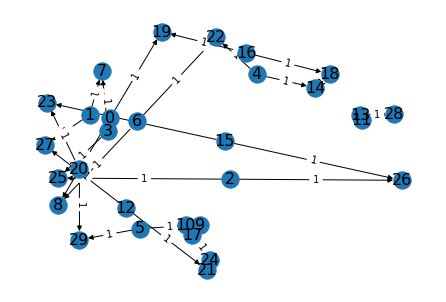

In [9]:
# Show winner graph of 1st experiment
exp = df.iloc[0]
        
G = games_to_graph(n_teams=exp["n_teams"], games=exp["results"], graph="winner")

pos=nx.spring_layout(G)
nx.draw(G, pos)
labels = nx.get_edge_attributes(G,'weight')
nx.draw_networkx_edge_labels(G,pos, edge_labels=labels)
labels= {i: node for i, node in enumerate(range(exp["n_teams"]))}
nx.draw_networkx_labels(G,pos,labels=labels,font_size=16)